In [9]:
import os
import json
import numpy as np
import torch
import collections
from Bio import SeqIO

t5dir_disprot = "../loss_T5_disprot"
esm2dir = "../loss_ESM2_disprot"

t5_dict = {}
esm2_dict = {}
datadict = {}

t5_jsons   = os.listdir(t5dir_disprot+"/matches")
esm2_jsons = os.listdir(esm2dir+"/matches")

common_files = list(set.intersection(set(t5_jsons), set(esm2_jsons)))
print(common_files)

print("Loading T5")
for filename in os.listdir(t5dir_disprot+"/matches"):
    if filename.endswith(".json") and filename in common_files:
        uniprot_id = filename.split("_")[0]
        print(f"{uniprot_id} ", end="")
        with open(os.path.join(t5dir_disprot, "matches", filename)) as f:
            data = json.load(f)
            t5_dict[uniprot_id] = data

print("Loading ESM2")
for filename in os.listdir(esm2dir+"/matches"):
    if filename.endswith(".json") and filename in common_files:
        uniprot_id = filename.split("_")[0]
        print(f"{uniprot_id} ", end="")
        with open(os.path.join(esm2dir, "matches", filename)) as f:
            data = json.load(f)
            esm2_dict[uniprot_id] = data

datadict = collections.defaultdict(dict)
for record in SeqIO.parse("../disprot_OK_fullset.fasta", "fasta"):
    uniprot_id = record.id
    seq = str(record.seq)
    datadict[uniprot_id]['seq'] = seq

for record in SeqIO.parse("../disprot_OK_fullset_annotations.fasta", "fasta"):
    uniprot_id = record.id
    seq = str(record.seq)
    datadict[uniprot_id]['disorder'] = seq

print(f"\nLoaded {len(datadict.keys())} proteins")

new_datadict = collections.defaultdict(dict)
for record in SeqIO.parse("../disprot_OK_fullset_12_2023.fasta", "fasta"):
    uniprot_id = record.id
    seq = str(record.seq)
    new_datadict[uniprot_id]['seq'] = seq

for record in SeqIO.parse("../disprot_OK_fullset_annotations_12_2023.fasta", "fasta"):
    uniprot_id = record.id
    seq = str(record.seq)
    new_datadict[uniprot_id]['disorder'] = seq

print(f"Loaded {len(new_datadict.keys())} proteins")

['P04083_matches.json', 'P18615_matches.json', 'P03347_matches.json', 'Q14019_matches.json', 'P48439_matches.json', 'P08067_matches.json', 'P35269_matches.json', 'F1QR43_matches.json', 'P10175_matches.json', 'O53168_matches.json', 'G5EFZ1_matches.json', 'P0ABJ3_matches.json', 'P02655_matches.json', 'P00734_matches.json', 'P22531_matches.json', 'P12464_matches.json', 'P19793_matches.json', 'Q39026_matches.json', 'P04147_matches.json', 'Q9NQA5_matches.json', 'Q47184_matches.json', 'P10415_matches.json', 'P97784_matches.json', 'P01009_matches.json', 'Q9JIH2_matches.json', 'P0A9A6_matches.json', 'P04968_matches.json', 'Q5UPT2_matches.json', 'P01094_matches.json', 'P00392_matches.json', 'Q10589_matches.json', 'Q87P35_matches.json', 'P02259_matches.json', 'P9WNK3_matches.json', 'E6PBU3_matches.json', 'A6NF83_matches.json', 'P01100_matches.json', 'F2Z293_matches.json', 'P03496_matches.json', 'P05055_matches.json', 'Q9ERE3_matches.json', 'Q9UKX7_matches.json', 'P28327_matches.json', 'O43236_ma

In [4]:
common_uniprots = sorted(set.intersection(set(t5_dict.keys()), set(esm2_dict.keys())))
len(common_uniprots)

99

In [10]:
import torch

matches_data = []
matched_uniprots = []
for uniprot_id in common_uniprots:
    if uniprot_id not in new_datadict:
        continue
    L = len(datadict[uniprot_id]['seq'])
    this_seq = datadict[uniprot_id]['seq']
    
    print(uniprot_id, L)
  
    ## Get aa-level losses
    # load losses from json
    if os.path.exists(os.path.join(t5dir_disprot, "losses", uniprot_id + "_losses.json")):
        T5_aaloss_sequences   = json.load(open(os.path.join(t5dir_disprot, "losses", uniprot_id + "_losses.json")))
        ESM2_aaloss_sequences = json.load(open(os.path.join(esm2dir, "losses", uniprot_id + "_losses.json")))
        print(f"{uniprot_id} loaded")
    else:
        print(f"{uniprot_id} not found")
        raise

    if os.path.exists(os.path.join(t5dir_disprot, "losses", uniprot_id + "_unmasked_losses.json")):
        T5_unmasked_aaloss_sequence   = json.load(open(os.path.join(t5dir_disprot, "losses", uniprot_id + "_unmasked_losses.json")))
        ESM2_unmasked_aaloss_sequence = json.load(open(os.path.join(esm2dir, "losses", uniprot_id + "_unmasked_losses.json")))   
    else:
        raise

    diso_ix = [True if e != "-" else False for e in datadict[uniprot_id]['disorder'] ]
    matches = t5_dict[uniprot_id]
    this_matches_data = []
    for pos,e in enumerate(matches):

        disotype = datadict[uniprot_id]['disorder'][pos]
        disotype2023 = new_datadict[uniprot_id]['disorder'][pos]
        ## TODO: Record the AA-level and prot-level loss
        ## Also add region-level loss?
        if e == True:
            ## record on-site match
            this_matches_data.append([f"{uniprot_id}_{pos}", True, disotype, disotype2023, T5_aaloss_sequences[pos][pos], ESM2_aaloss_sequences[pos][pos], T5_unmasked_aaloss_sequence[pos], ESM2_unmasked_aaloss_sequence[pos]])
        else:
            this_pos_found = False
            for mismatch_aa in e:
                if pos == mismatch_aa[0]:
                    ## record on-site mismatch
                    this_matches_data.append([f"{uniprot_id}_{pos}", False, disotype, disotype2023, T5_aaloss_sequences[pos][pos], ESM2_aaloss_sequences[pos][pos], T5_unmasked_aaloss_sequence[pos], ESM2_unmasked_aaloss_sequence[pos]])
                    this_pos_found = True
            if not this_pos_found:
                ## record on-site mismatch, though there are offsite mismatches
                this_matches_data.append([f"{uniprot_id}_{pos}", True, disotype, disotype2023, T5_aaloss_sequences[pos][pos], ESM2_aaloss_sequences[pos][pos], T5_unmasked_aaloss_sequence[pos], ESM2_unmasked_aaloss_sequence[pos]])
    matches_data.append(this_matches_data)
    matched_uniprots.append(uniprot_id)

A6NF83 97
A6NF83 loaded
B0FRH7 120
B0FRH7 loaded
E6PBU3 143
E6PBU3 loaded
F1QR43 586
F1QR43 loaded
F2Z293 243
F2Z293 loaded
G5EFZ1 539
G5EFZ1 loaded
O00522 736
O00522 loaded
O25010 73
O25010 loaded
O32728 250
O32728 loaded
O43236 478
O43236 loaded
O53168 472
O53168 loaded
O95149 360
O95149 loaded
P00004 105
P00004 loaded
P00392 561
P00392 loaded
P00734 622
P00734 loaded
P01009 418
P01009 loaded
P01094 68
P01094 loaded
P01100 380
P01100 loaded
P02259 190
P02259 loaded
P02315 70
P02315 loaded
P02511 175
P02511 loaded
P02655 101
P02655 loaded
P03265 529
P03265 loaded
P03347 512
P03347 loaded
P03496 230
P03496 loaded
P04083 346
P04083 loaded
P04147 577
P04147 loaded
P04156 253
P04156 loaded
P04610 86
P04610 loaded
P04637 393
P04637 loaded
P04968 514
P04968 loaded
P05055 711
P05055 loaded
P08067 215
P08067 loaded
P09883 582
P09883 loaded
P0A9A6 383
P0A9A6 loaded
P0ABJ3 204
P0ABJ3 loaded
P0AD27 586
P0AD27 loaded
P0AES9 110
P0AES9 loaded
P0AFC3 147
P0AFC3 loaded
P0CF51 173
P0CF51 loaded
P0CU5

E6PBU3_0, masked T5 AUC: 0.47096774193548385
E6PBU3_0, masked ESM2 AUC: 0.4230107526881721
E6PBU3_0, unmasked T5 AUC: 0.5868817204301076
E6PBU3_0, unmasked ESM2 AUC: 0.39311827956989254
F1QR43_0, masked T5 AUC: 0.7574145712443584
F1QR43_0, masked ESM2 AUC: 0.8399419729206964
F1QR43_0, unmasked T5 AUC: 0.5544003868471953
F1QR43_0, unmasked ESM2 AUC: 0.8382495164410059
F2Z293_0, masked T5 AUC: 0.6271735926908341
F2Z293_0, masked ESM2 AUC: 0.6493516062481578
F2Z293_0, unmasked T5 AUC: 0.3983200707338638
F2Z293_0, unmasked ESM2 AUC: 0.6548040082522841
G5EFZ1_0, masked T5 AUC: 0.7234358974358975
G5EFZ1_0, masked ESM2 AUC: 0.6806666666666666
G5EFZ1_0, unmasked T5 AUC: 0.4600512820512821
G5EFZ1_0, unmasked ESM2 AUC: 0.6741025641025641
O00522_0, masked T5 AUC: 0.7852037617554859
O00522_0, masked ESM2 AUC: 0.8841379310344828
O00522_0, unmasked T5 AUC: 0.45141065830721006
O00522_0, unmasked ESM2 AUC: 0.8807523510971788
O25010_0, masked T5 AUC: 0.5488372093023256
O25010_0, masked ESM2 AUC: 0.5565

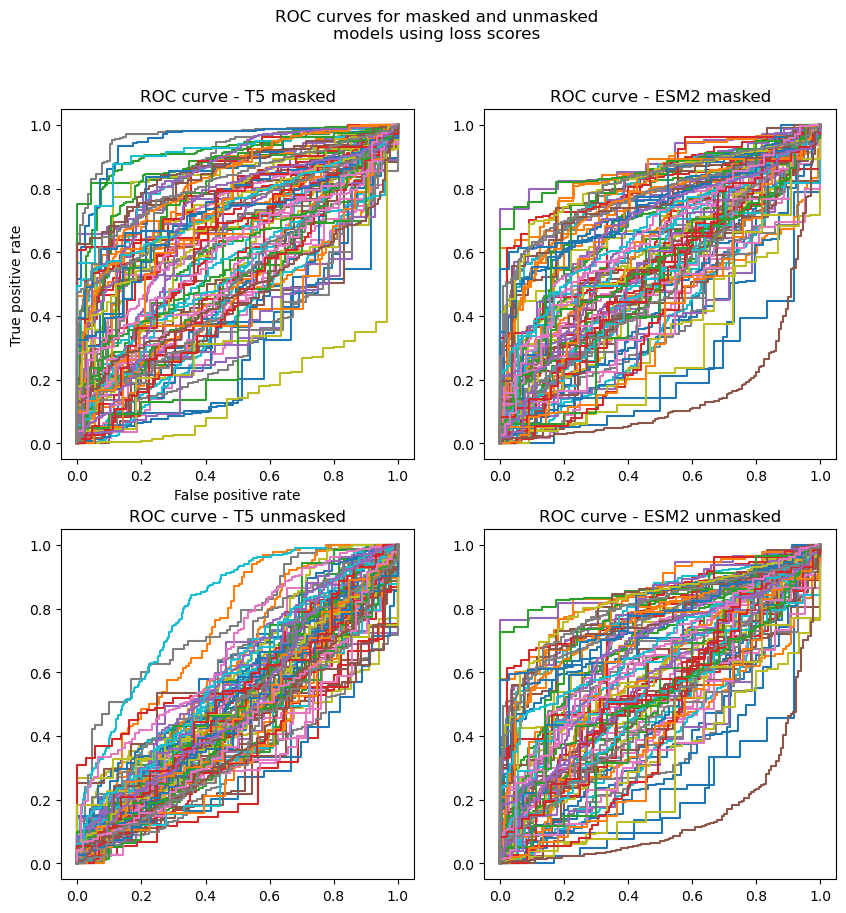

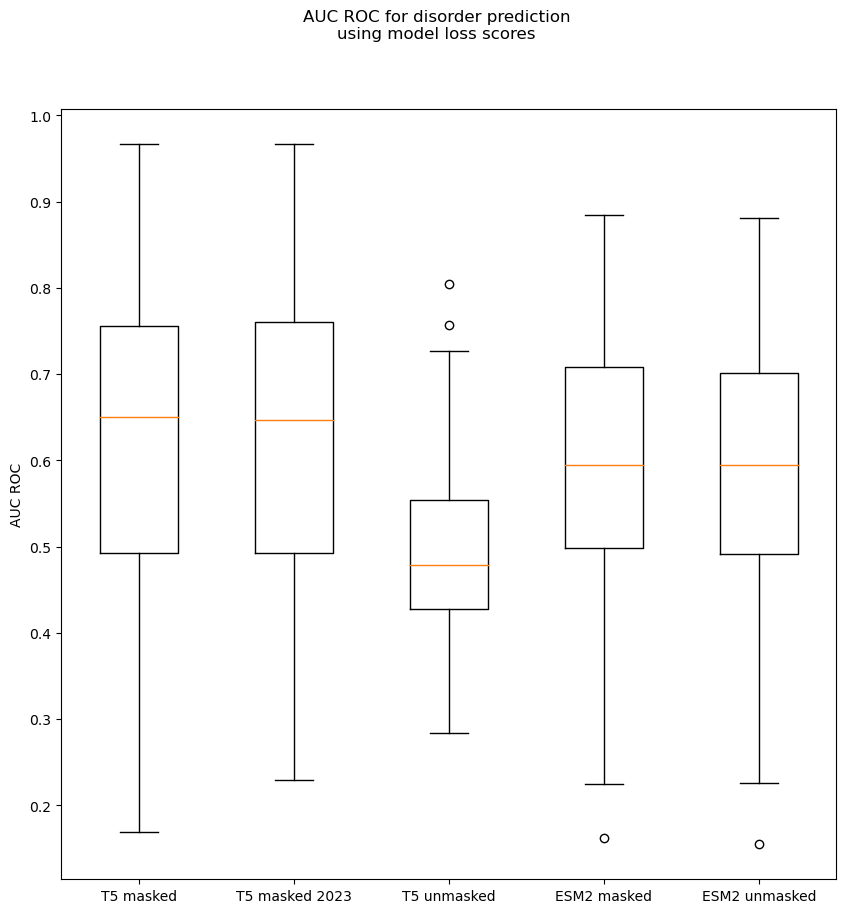

In [15]:
# calculate AUC ROC curve using matches_data[0], using position 3 as score
from sklearn.metrics import roc_auc_score
import pandas as pd
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10), dpi=100)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
aucs_masked_T5 = []
aucs_masked_ESM2 = []
aucs_unmasked_T5 = []
aucs_unmasked_ESM2 = []
aucs_masked_T5_2023 = []
uniprots_aucs = []
for i in range(len(matches_data)):

    df = pd.DataFrame(matches_data[i], columns=["id", "match", "diso", "diso23", "loss_T5", "loss_ESM2", "unmasked_loss_T5", "unmasked_loss_ESM2"])

    # invert the loss
    df["loss_T5"] = -df["loss_T5"]
    df["loss_ESM2"] = -df["loss_ESM2"]
    df["unmasked_loss_T5"] = -df["unmasked_loss_T5"]
    df["unmasked_loss_ESM2"] = -df["unmasked_loss_ESM2"]

    # obtain structure true labels
    df["diso"] = df['diso'] == "-"
    df["diso23"] = df['diso23'] == "-"

    if all(df["diso"]) or np.sum(df["diso"]) == 0:
        continue
    if all(df["diso23"]) or np.sum(df["diso23"]) == 0:
        continue
        

    aucs_masked_T5.append(roc_auc_score(df['diso'], df['loss_T5']))
    aucs_masked_ESM2.append(roc_auc_score(df['diso'], df['loss_ESM2']))
    aucs_unmasked_T5.append(roc_auc_score(df['diso'], df['unmasked_loss_T5']))
    aucs_unmasked_ESM2.append(roc_auc_score(df['diso'], df['unmasked_loss_ESM2']))
    aucs_masked_T5_2023.append(roc_auc_score(df['diso23'], df['loss_T5']))

    uniprots_aucs.append(matched_uniprots[i])
    
    print(f"{df['id'][0]}, masked T5 AUC: {roc_auc_score(df['diso'], df['loss_T5'])}")
    print(f"{df['id'][0]}, masked ESM2 AUC: {roc_auc_score(df['diso'], df['loss_ESM2'])}")
    print(f"{df['id'][0]}, unmasked T5 AUC: {roc_auc_score(df['diso'], df['unmasked_loss_T5'])}")
    print(f"{df['id'][0]}, unmasked ESM2 AUC: {roc_auc_score(df['diso'], df['unmasked_loss_ESM2'])}")


    # plot the roc curve
    fpr, tpr, thresholds = roc_curve(df["diso"], df["loss_T5"])
    ax1.plot(fpr, tpr)
    fpr, tpr, thresholds = roc_curve(df["diso"], df["loss_ESM2"])
    ax2.plot(fpr, tpr)
    fpr, tpr, thresholds = roc_curve(df["diso"], df["unmasked_loss_T5"])
    ax3.plot(fpr, tpr)
    fpr, tpr, thresholds = roc_curve(df["diso"], df["unmasked_loss_ESM2"])
    ax4.plot(fpr, tpr)
    
    #add labels
    ax1.set_xlabel("False positive rate")
    ax1.set_ylabel("True positive rate")
    ax1.set_title("ROC curve - T5 masked")
    ax2.set_title("ROC curve - ESM2 masked")
    ax3.set_title("ROC curve - T5 unmasked")
    ax4.set_title("ROC curve - ESM2 unmasked")
plt.suptitle("ROC curves for masked and unmasked\nmodels using loss scores")
plt.show()

# make a boxplot of the AUCs
fig = plt.figure(figsize=(10,10), dpi=100)
ax = fig.add_subplot(111)
ax.boxplot([aucs_masked_T5, aucs_masked_T5_2023, aucs_unmasked_T5, aucs_masked_ESM2, aucs_unmasked_ESM2])
ax.set_xticklabels(["T5 masked", "T5 masked 2023", "T5 unmasked", "ESM2 masked", "ESM2 unmasked"])
ax.set_ylabel("AUC ROC")
plt.suptitle("AUC ROC for disorder prediction\nusing model loss scores")
plt.show()




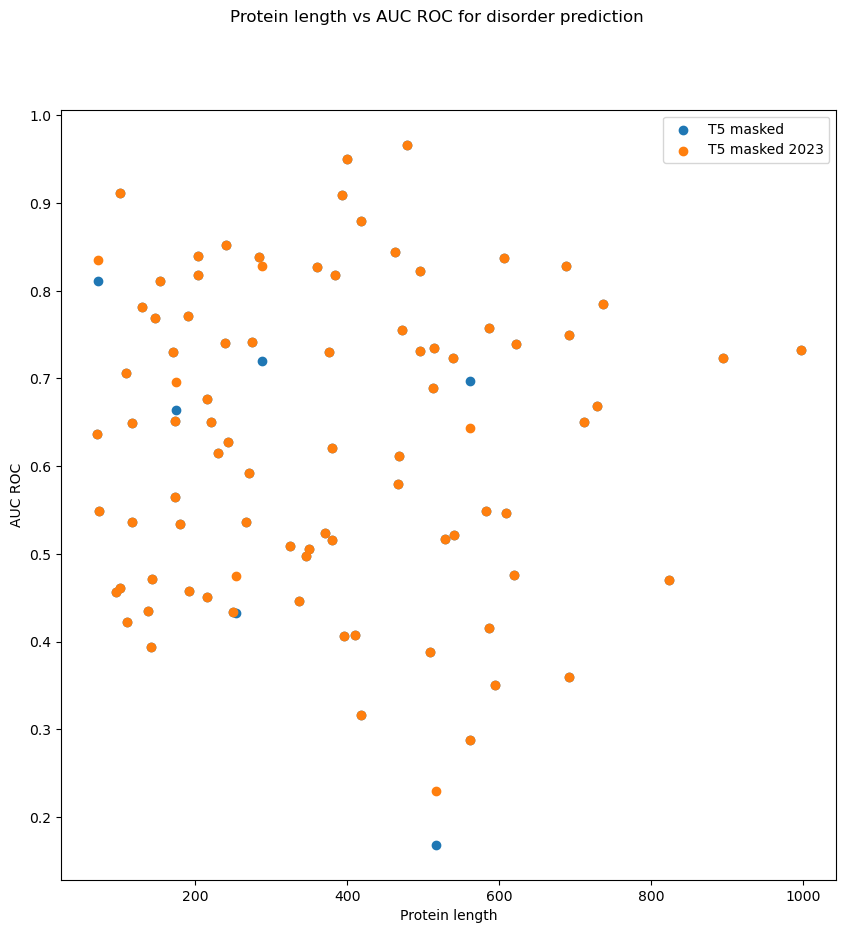

In [17]:
# plot protein length vs AUC ROC
fig = plt.figure(figsize=(10,10), dpi=100)
ax = fig.add_subplot(111)
ax.scatter([len(datadict[uniprot_id]['seq']) for uniprot_id in uniprots_aucs], aucs_masked_T5, label="T5 masked")
#ax.scatter([len(datadict[uniprot_id]['seq']) for uniprot_id in uniprots_aucs], aucs_unmasked_T5, label="T5 unmasked")
#ax.scatter([len(datadict[uniprot_id]['seq']) for uniprot_id in uniprots_aucs], aucs_masked_ESM2, label="ESM2 masked")
#ax.scatter([len(datadict[uniprot_id]['seq']) for uniprot_id in uniprots_aucs], aucs_unmasked_ESM2, label="ESM2 unmasked")
ax.scatter([len(datadict[uniprot_id]['seq']) for uniprot_id in uniprots_aucs], aucs_masked_T5_2023, label="T5 masked 2023")
ax.set_xlabel("Protein length")
ax.set_ylabel("AUC ROC")
ax.legend()
plt.suptitle("Protein length vs AUC ROC for disorder prediction")
plt.show()


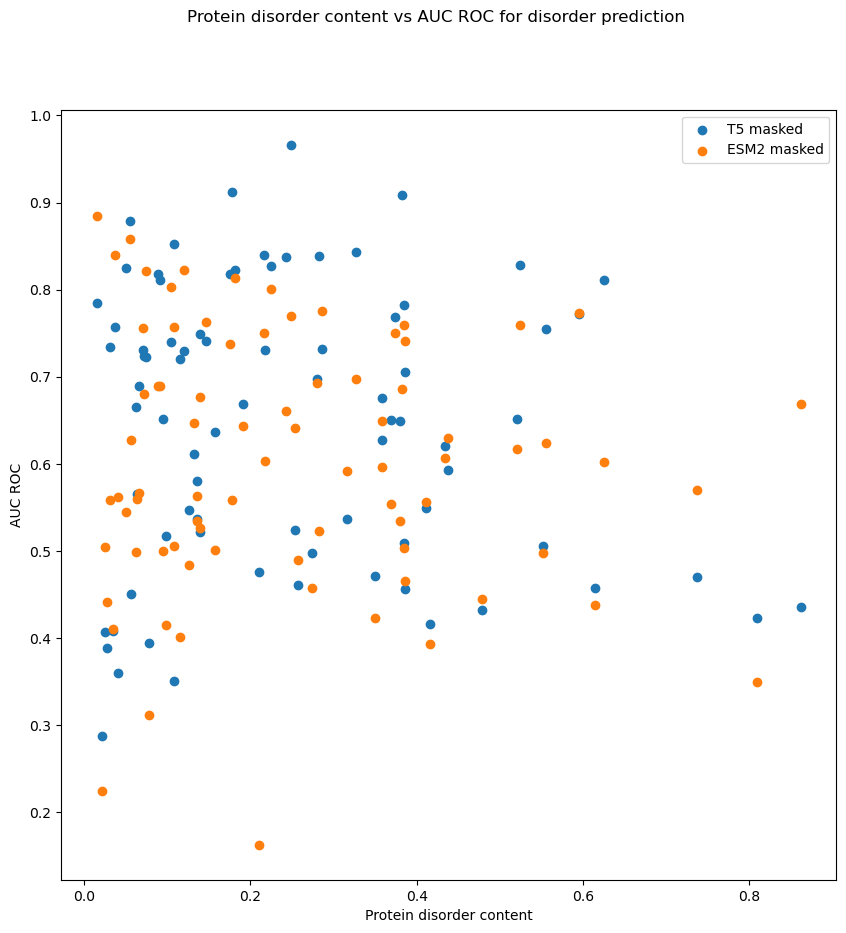

In [29]:
# plot protein disorder content vs AUC ROC. protein disorder content is calculated as the fraction of disordered positions over the length of the protein
fig = plt.figure(figsize=(10,10), dpi=100)
ax = fig.add_subplot(111)
ax.scatter([np.sum([e != "-" for e in datadict[uniprot_id]['disorder']])/len(datadict[uniprot_id]['disorder']) for uniprot_id in uniprots_aucs], aucs_masked_T5, label="T5 masked")
#ax.scatter([np.sum([e == "-" for e in datadict[uniprot_id]['disorder']])/len(datadict[uniprot_id]['disorder']) for uniprot_id in uniprots_aucs], aucs_unmasked_T5, label="T5 unmasked")
ax.scatter([np.sum([e != "-" for e in datadict[uniprot_id]['disorder']])/len(datadict[uniprot_id]['disorder']) for uniprot_id in uniprots_aucs], aucs_masked_ESM2, label="ESM2 masked")
#ax.scatter([np.sum([e == "-" for e in datadict[uniprot_id]['disorder']])/len(datadict[uniprot_id]['disorder']) for uniprot_id in uniprots_aucs], aucs_unmasked_ESM2, label="ESM2 unmasked")
ax.set_xlabel("Protein disorder content")
ax.set_ylabel("AUC ROC")
ax.legend()
plt.suptitle("Protein disorder content vs AUC ROC for disorder prediction")
plt.show()


In [32]:
import json

def pretty_print_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)

    with open(file_path, 'w') as f:
        json.dump(data, f, indent=4)

pretty_print_json("../loss_T5_disprot/Q96SD1.json")